# ToDO 
- Link to API
- Remove compute!
- plot_microstructures add axes / or remove it completely
- Discuss the last part

# Two Point Spatial Correlation Calculation

In this notebook, we are demonstrating simple case studies for calculating 2-point spatial correlations on experimental microstructure and synthetic (generated) microstructures. First, we will demonstrate how to calculate spatial correlations for a single 2 phase experimental image. Then, we will demonstrate the most efficient way to calculate 2-point spatial correlations on multiple microstructures without using any for-loop. We will only use common python packages like `numpy`,`scikit-learn`, and `matplotlib` for this introductory notebook. For parallel (`dask`) and pipeline implementation please see the [Effective Stiffness of a Composite Material example](./stress.ipynb) and [Effective Stiffness of Fiber Composite](./fiber.ipynb) 

Importing necessary packages to perform 2-point spatial correlations calculations

In [54]:
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore')

import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

In [55]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the Experimental Data


Let's read and visualize the experimental microstructure! This example is a segmented optical image. To obtain the statistical representation of the grain morphology, grain interior and grain boundaries are the two different phases here[[1]](#References). 


In [83]:
ls

'Notebook for 2pt stats and PCA-Copy1.ipynb'   elasticity3d.ipynb
'Notebook for 2pt stats and PCA.ipynb'         fiber.ipynb
 TwoPointStatsBasic.ipynb                      filter.ipynb
 Untitled.ipynb                                how_to_two_point_stats.ipynb
 cahn_hilliard.ipynb                           image.tiff
 cahn_hilliard_legendre.ipynb                  intro.ipynb
 checkerboard.ipynb                            multiphase.ipynb
 derivation.ipynb                              sanitize.cfg
 domain.vtk                                    stress.ipynb
 elasticity.ipynb                              tech_overview.ipynb


In [87]:
 from PIL import Image
im = Image.open('pymks/datasets/image.tiff')
plt.imshow(im,cmap='gray')
plt.title("2 Phase Segmented Experimental Image")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pymks/datasets/image.tiff'

## Calculating the 2-point Stats

PyMKS can handle both `numpy` and `dask` arrays. For simplicity, we will use `numpy` arrays for this notebook. Note that `PyMKS` require certain data shapes for proper 2-point spatial correlation calculation. For two-dimensional microstructure (2-D),` PyMKS` requires a 4-dimensional array. The first dimension is the sample axis, the second dimension is the x-axis, the third dimension is the y-axis, and the fourth dimension is the phase axis. In the phase axis, the specific phase gets '1's and the rest of the image gets '0's. For this example, we have a 2-phase segmented microstructure(986 x 1376) so we need to perform some array manipulations to obtain a 1 x 986 x 1376 x 2 array. 

Let's convert the image to a `numpy` array and add the sample axis by using `np.expand_dims`function. If you have multiple images you can simply stack them by using `numpy` data manipulation functions.

In [57]:
imarray = np.array(im)
imarray = np.expand_dims(imarray,axis=0)

In [58]:
imarray.shape

(1, 986, 1376)

Now let's add the phase axis. Since this is a binary microstructure, we can simply stack the inverted version of the image to the original image. However, we are going to demonstrate the `PrimitiveTransformer` that performs the same operation and this transformer can be used for more complex cases (higher number phases and continuous values for phase information).

In [59]:
nx_data=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(imarray).compute()

In [60]:
nx_data.shape

(1, 986, 1376, 2)

`PrimitiveTransformer` created the (1 x 986 x 1376 x 2) array where the last axis has the phase information. For this 2-phase 2D microstructure example, we have two 2D arrays where the first phase (grain interior) get `1's` at `[0,:,:,0]`, and the second phase (grain boundary) gets the `1's` at `[0,:,:,1]` 

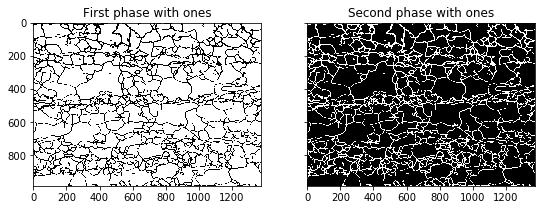

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].imshow(nx_data[0,:,:,0],cmap='gray')
axs[0].title.set_text('First phase with ones')
axs[1].imshow(nx_data[0,:,:,1],cmap='gray')
axs[1].title.set_text('Second phase with ones')
plt.show()

After obtaining the data matrix with the desired shape, calculating two-point correlations are pretty straightforward. We just need to call the `TwoPointCorrelation` class and perform the `.transform` method. Parameters for the `TwoPointCorrelation` class:  `periodic_boundary` defines the boundary condition ( periodic or non-periodic boundary), `cutoff` defines the maximum correlation vector length, and `correlations` sets the interested autocorrelations and cross-correlations (i.e. `(0,0)` means autocorrelation of the first phase,`(0,1)` means crosscorrelation between the first phase and the second phase)

In [62]:
TwoPt = TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0)])
AutoCorrelation = TwoPt.transform(nx_data).compute()

In [63]:
AutoCorrelation.shape

(1, 51, 51, 1)

There is also a built-in correlation visualization function (`plot_microstructures`) for Pymks. `matplotlib` functions can also be used for custom 2-pt stats visualization. The visualization of the grain interior autocorrelation is shown below. 

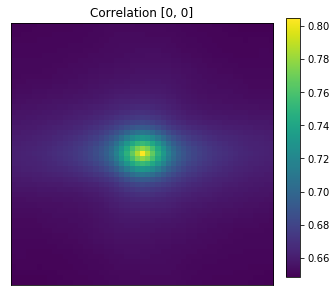

In [64]:
plot_microstructures(
    AutoCorrelation[0, :, :, 0],
    titles=['Correlation [0, 0]']
)

# Multiple Synthetic Microstructures

In the previous section, we demonstrated a 2-point spatial correlation calculation for a single experimental image. Now we will demonstrate calculating 2-point correlations for multiple microstructure images without using any for loops. It is a similar procedure and we only need to create the input array where  the first dimension is the sample axis, the  second dimension is the x-axis, the third dimension is y-axis, and the fourth dimension is the phase axis


Let's generate 40 different 2-phased   syntetic microstructures with `100x100` shape using `generate_multiphase`. [Effective Siffness of a Composite Material example](./stress.ipynb) notebook has detailed explanation for the `generate_multiphase` function. 


In [80]:
da.random.seed(10)
np.random.seed(10)

nx_data = da.concatenate([
    generate_multiphase(shape=(10, 100, 100), grain_size=grain_size,
        volume_fraction=volume_fraction,
        percent_variance=0.2
    )
    for (grain_size, volume_fraction) in zip(
        [(30, 2), (10, 20), (25, 25), (20, 10)],
        [(0.7, 0.3), (0.6, 0.4), (0.3, 0.7), (0.4, 0.6)]
    )
]).persist()


In [81]:
nx_data.shape


(40, 100, 100)

Let's visualize some synthetic microstructures.

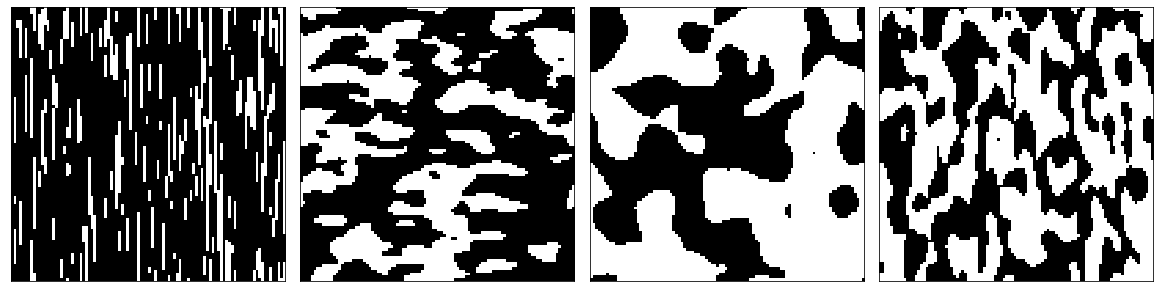

In [67]:
plot_microstructures(*nx_data[::10], cmap='gray', colorbar=False)

As performed in the previous case study, we need to create the 4-dimensional input array for 2-point spatial correlation calculation. `PrimitiveTransformer` can be used for multiple microstructure data as well.

In [68]:
nx_data=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(nx_data).compute()

In [69]:
nx_data.shape

(40, 100, 100, 2)

Again, `PrimitiveTransformer` created the for dimensional array where the last axis has the phase information. Now we can simply use the `TwoPointCorrelation` class to calculate 2-point spatial correlations (`(0,0),(0,1)`) for all 40 microstructures.

In [70]:
TwoPt=TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0),(0,1)])
AutoCorrelation=TwoPt.transform(nx_data).compute()

In [71]:
AutoCorrelation.shape

(40, 51, 51, 2)

Last axis of the `AutoCorrelation` array contains the requested auto-correlations and cross-correlations (i.e. `[0,:,:,1]` is `(0,1)` cross-correlation of the first microstructure . 

Let's visualize some of the 2-point correlations.



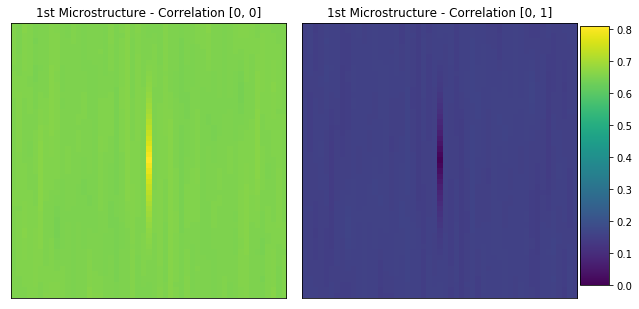

In [72]:
plot_microstructures(
    AutoCorrelation[0, :, :, 0],
    AutoCorrelation[0, :, :, 1],
    titles=['1st Microstructure - Correlation [0, 0]', '1st Microstructure - Correlation [0, 1]']
)

# Do we want to include PCA?

Then we flatten this data to use PCA

In [73]:
flatten=FlattenTransformer().transform(AutoCorrelation)

As you can see all the correlation information was flatten. Each row contains information for a single microstructure

In [74]:
flatten.shape

(40, 5202)

Then we do the PCA.

In [75]:
PC_scores=PCA(svd_solver='full', n_components=5).fit(flatten).transform(flatten)

Now we calculated the PC scores for each microstructure

In [76]:
PC_scores

array([[ 1.86850222e+01,  3.80953416e+00, -8.49110809e-02,
        -2.79539142e-01,  1.01894214e-01],
       [-1.24501424e+00, -1.80689696e+00,  1.20165740e+00,
        -1.57114955e-01, -4.03899408e-01],
       [ 1.43621867e+01,  2.06008941e+00,  2.44811650e-01,
        -2.43813876e-01, -7.37556905e-02],
       ...,
       [-9.24016313e+00, -3.30094090e-01,  4.11078869e-01,
        -1.94200814e-02,  2.46753458e-01],
       [ 1.90160499e+00, -1.58892407e+00, -8.26380653e-03,
        -2.90587937e-01,  6.04668132e-01],
       [-2.32415345e+00, -1.83914995e+00,  6.00734108e-02,
        -1.41905790e-01,  3.68007813e-01]])

Finally lets visualize 

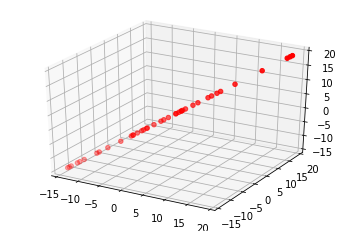

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC_scores[:,0], PC_scores[:,0], PC_scores[:,0], c='r', marker='o')
plt.show()

In [78]:
PC_scores[:,:3].shape

(40, 3)

# References

[1]  Yucel, B., Yucel, S., Ray, A. et al. Mining the Correlations Between Optical Micrographs and Mechanical Properties of Cold-Rolled HSLA Steels Using Machine Learning Approaches. Integr Mater Manuf Innov 9, 240–256 (2020). https://doi.org/10.1007/s40192-020-00183-3